# Customer Segmentation using RFM Analysis and K-means Clustering--Targeting Campaign AB Testing


RFM analysis is a classic model for evaluating customer value and behavioral tendencies based on their historical behaviors (such as purchase time, frequency, and amount). It helps businesses identify high-value customers, potential customers, and churned customers, and is an important tool in precision marketing and Customer Relationship Management (CRM).

| Metric | Meaning | Calculation Method | Business Significance |
|---|---|---|---|
| R (Recency) | Number of days since the customer's last purchase | Current Date - Last Purchase Date | The smaller the value, the more active the customer |
| F (Frequency) | Number of purchases within a specific period | Count of distinct orders (or invoices) | The higher the value, the stronger the customer loyalty |
| M (Monetary) | Total consumption amount | Sum of all order amounts | The higher the value, the greater the customer value |

# __STEP 1: Data Processing__

In [2]:
import pandas as pd
import numpy as np
import datetime

df=pd.read_csv('customer_transactions_RFM.csv')

In [3]:
df.head(5)

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalAmount,Category,Country,Channel,Age,Gender,Membership,RegistrationDate,Occupation
0,C03649,INV126225,2025-01-29,5,19.82,99.10,Home,UK,Online,35,Female,NaN,2024-09-10,Sales
1,C04573,INV872246,2023-04-15,1,87.29,87.29,Books,India,Mobile,21,Other,NaN,2024-08-18,Sales
2,C02849,INV719176,2024-03-08,3,97.14,291.42,Electronics,USA,Online,27,Other,Silver,2023-02-22,Student
3,C07165,INV343962,2024-06-01,3,22.42,67.26,Toys,USA,Mobile,24,Female,NaN,2023-04-23,Manager
4,C06516,INV850800,2024-10-27,3,32.67,98.01,Books,China,In-store,30,Male,Gold,2023-05-14,Artist


### DataFrame Summary

This DataFrame contains 200,000 rows and 14 columns, capturing detailed transaction data for a diverse customer base. Each row represents one order line and includes customer demographics, transaction details, and product/category specifics.

| Column Name         | Description                          |
|---------------------|--------------------------------------|
| CustomerID          | Unique customer identifier           |
| InvoiceNo           | Transaction/Invoice number           |
| InvoiceDate         | Date of purchase                     |
| Quantity            | Number of items purchased            |
| UnitPrice           | Price per item                       |
| TotalAmount         | Total value for the transaction      |
| Category            | Product category (e.g., Toys, Books) |
| Country             | Customer’s country                   |
| Channel             | Sales channel (Online/Mobile/In-store)|
| Age                 | Customer age                         |
| Gender              | Customer gender                      |
| Membership          | Membership status (e.g., Gold, Silver)|
| RegistrationDate    | Date customer joined                 |
| Occupation          | Customer's occupation                |


In [4]:
# Import timedelta from datetime package
from datetime import timedelta


# Convert entire column from string to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Then get the max date
maxinvoiceDate = df['InvoiceDate'].max()

# Calculate snapshot_date (snapshot_date = max invoice date + 1 day) 
snapshot_date = maxinvoiceDate + timedelta(days=1)


In [5]:
snapshot_date

Timestamp('2025-08-02 00:00:00')

In [6]:
# Create a new dataframe called rfm (recency, frequency, monetary)
rfm=df.groupby('CustomerID').agg({
'InvoiceDate':lambda x: (snapshot_date - x.max()).days, #Recency
'InvoiceNo':'nunique',#Frequency
'TotalAmount':'sum' #Monetary
})

In [7]:
rfm

,InvoiceDate,InvoiceNo,TotalAmount
CustomerID,,,
C00001,7,12,2355.48
C00002,62,13,1375.04
C00003,275,8,1156.69
C00004,70,7,1692.09
C00005,16,9,1819.42
...,...,...,...
C19996,15,12,1751.18
C19997,93,12,1441.84
C19998,9,8,1243.01


### RFM DataFrame Summary

The RFM DataFrame aggregates 20,000 customers' transaction history to highlight three key metrics:

- **Recency**: Number of days since each customer’s last purchase (calculated using the most recent invoice date plus one).
- **Frequency**: Total number of unique invoices per customer, indicating purchase frequency.
- **Monetary**: Total spending (sum of all purchase amounts) for each customer.

This summary enables segmentation and analysis of customer value and engagement.


In [8]:
## change names of the rfm columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm

,Recency,Frequency,Monetary
CustomerID,,,
C00001,7,12,2355.48
C00002,62,13,1375.04
C00003,275,8,1156.69
C00004,70,7,1692.09
C00005,16,9,1819.42
...,...,...,...
C19996,15,12,1751.18
C19997,93,12,1441.84
C19998,9,8,1243.01


In [9]:
## Create R_score F_score M_score RFM_Score columns
## R_score: lower recency, higher R score ; higher frequncy, higher F score; higher monetary, higher M score
## RFM_score: Concanate R,F,M score. We do not sum them since different combinations with same summation result can't be revealed with summation method

rfm['R_score'] = pd.qcut(rfm['Recency'], 5,labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] =pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5,labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_score'].astype(str)+ rfm['F_score'].astype(str) +rfm['M_score'].astype(str)

In [10]:
rfm

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
C00001,7,12,2355.48,5,4,5,545
C00002,62,13,1375.04,3,4,3,343
C00003,275,8,1156.69,1,2,2,122
C00004,70,7,1692.09,3,1,4,314
C00005,16,9,1819.42,5,2,4,524
...,...,...,...,...,...,...,...
C19996,15,12,1751.18,5,4,4,544
C19997,93,12,1441.84,2,4,3,243
C19998,9,8,1243.01,5,2,2,522


In [12]:
rfm.to_csv('rfm.csv')


# __STEP 2: Exploratory Data Analysis__

<Axes: xlabel='F_score', ylabel='R_score'>

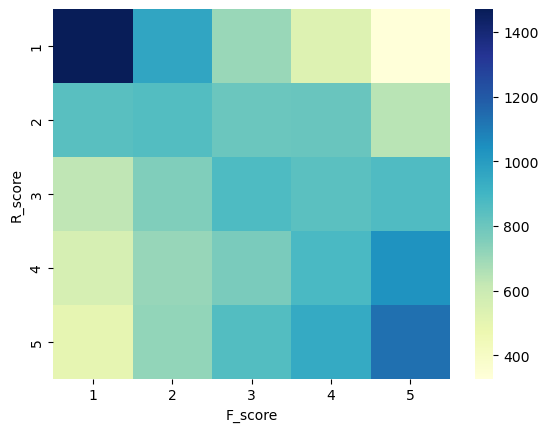

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
##热力图：客户分布在不同 R 和 F 分数的格子中
sns.heatmap(rfm.groupby(['R_score', 'F_score']).size().unstack(), cmap="YlGnBu")

_For customers who have high R_score, there are more of them having high F_score as well. For customers who have low R_score, there are more of them having low F_score as well._

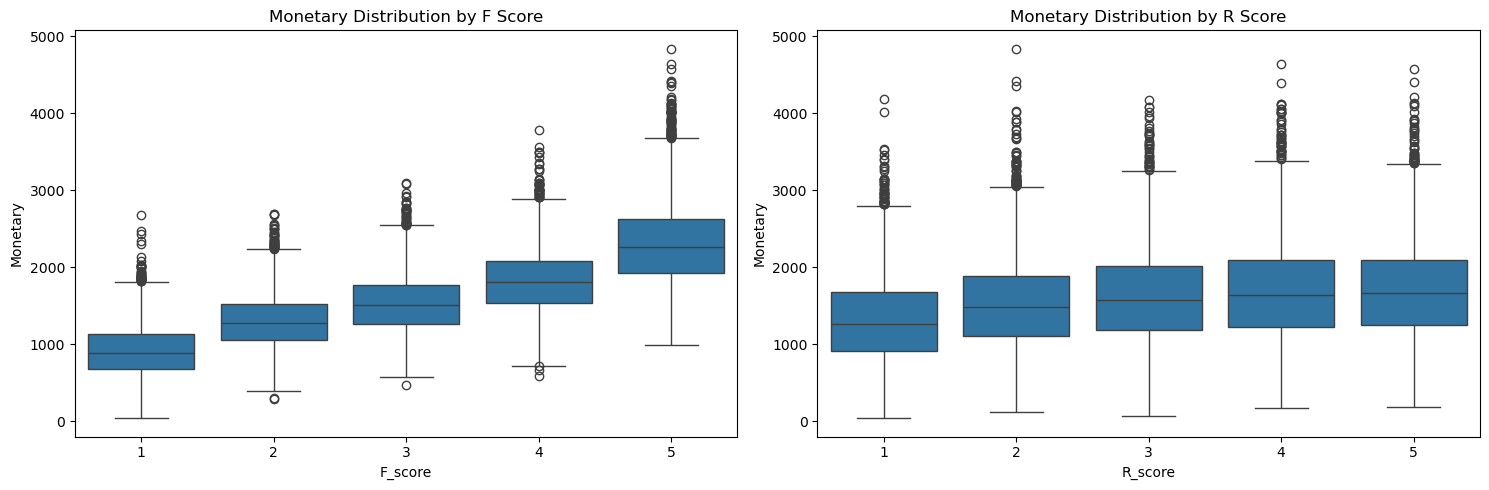

In [11]:
##Side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Left: F_score vs Monetary 箱线图：不同 F 分数的 Monetary 分布
sns.boxplot(data=rfm, x='F_score', y='Monetary', ax=ax1)
ax1.set_title('Monetary Distribution by F Score')

# Right: R_score vs Monetary   箱线图：不同 R 分数的 Monetary 分布;
sns.boxplot(data=rfm, x='R_score', y='Monetary', ax=ax2)
ax2.set_title('Monetary Distribution by R Score')

plt.tight_layout()
plt.show()

_higher F_score and R_score is associated with higher total order amount. It makes intuitive sense_

<Axes: xlabel='RFM_Class'>

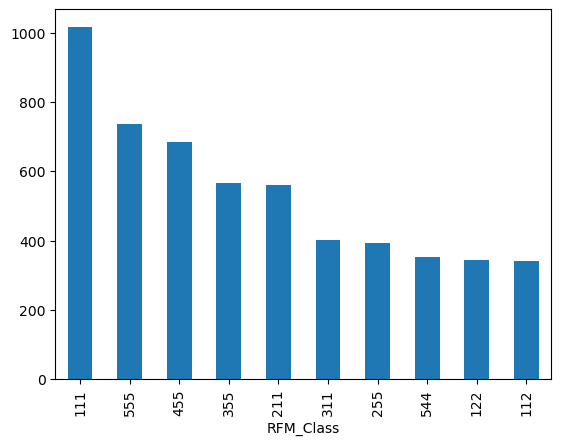

In [12]:
##柱状图：不同 RFM 分组的客户数量
rfm['RFM_Class'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Class'].value_counts().head(10).plot(kind='bar')

_For customers who have high R_score, there are more of them having high F_score as well. For customers who have low R_score, there are more of them having low F_score as well. '111' and '555' are the most common customer FRM Class._

# RFM Segmentation and Customer Label Examples
Customers can be categorized into multiple segments based on RFM score combination rules.

| Customer Type | Recency | Frequency | Monetary | Description | Marketing Strategy |
|---|---|---|---|---|---|
| Super Customers | High (5) | High (5) | High (5) | High activity + High frequency + High spending | Send membership rewards and exclusive offers |
| Loyal Customers | Medium | High | High | Regular purchasers with strong loyalty | Provide VIP treatment and loyalty programs |
| New Customers | High | Low | Low | Recently acquired, limited purchase history | Welcome series, onboarding guidance, and introductory offers |
| Churned Customers | Low (1) | Low | Low | Inactive for a long time, likely lost | Win-back campaigns with special discount coupons |
| Potential Customers | High | Medium | High | Recent high-value purchasers with growth potential | Push new product recommendations and cross-selling opportunities |

## Precision Marketing Strategies
- **High-value customers**: Send membership rewards and exclusive privileges
- **Potential customers**: Push new product recommendations and personalized suggestions
- **Churned customers**: Send win-back coupon offers and reactivation campaigns

## Customer Retention Analysis
- **Which groups are prone to churn?** (Low R + Low F) → User retention strategies
- **Which groups have potential to become loyal customers?** (High R + Medium F + Medium M) → Loyal customer transition strategies

# __STEP 3: Scale the Variables__

### Understanding StandardScaler

**StandardScaler** is a preprocessing utility from scikit-learn that standardizes features by removing the mean and scaling to unit variance. After transformation, each feature will have:

- Mean (μ) = 0
- Standard deviation (σ) = 1

Mathematical Transformation

For each value `x_i` in a feature column, StandardScaler applies:
- `z_i` = (`x_i` - `μ`) / `σ`


**Where:**
- `μ` = mean of the feature
- `σ` = standard deviation of the feature

This transformation centers all features around zero and ensures consistent scaling across variables.

### Equal Feature Contribution
Features with different measurement scales (e.g., recency in days, frequency as counts, monetary value in dollars) can disproportionately influence machine learning models. StandardScaler eliminates this bias by bringing all features to a common scale.

In [13]:
# Select RFM columns (Recency, Frequency, Monetary) from the dataframe
x = rfm[['Recency', 'Frequency', 'Monetary']]
x

,Recency,Frequency,Monetary
CustomerID,,,
C00001,7,12,2355.48
C00002,62,13,1375.04
C00003,275,8,1156.69
C00004,70,7,1692.09
C00005,16,9,1819.42
...,...,...,...
C19996,15,12,1751.18
C19997,93,12,1441.84
C19998,9,8,1243.01


In [14]:
# Import StandardScaler from scikit-learn preprocessing module
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it, scaling each feature to have mean=0 and std=1
x_scaled = scaler.fit_transform(x)

# The variable x_scaled now contains the standardized RFM values, 
# which are ready to be used for clustering or other modeling tasks.
x_scaled

array([[-0.93175383,  0.63724789,  1.24604399],
       [-0.34741363,  0.95586388, -0.32357247],
       [ 1.91557663, -0.63721603, -0.67313568],
       ...,
       [-0.9105051 , -0.63721603, -0.53494335],
       [-0.4855304 ,  1.59309584,  1.51070984],
       [-0.50677914,  0.95586388,  2.16806798]])

# __STEP 4: K Means Clustering-Choosing k__

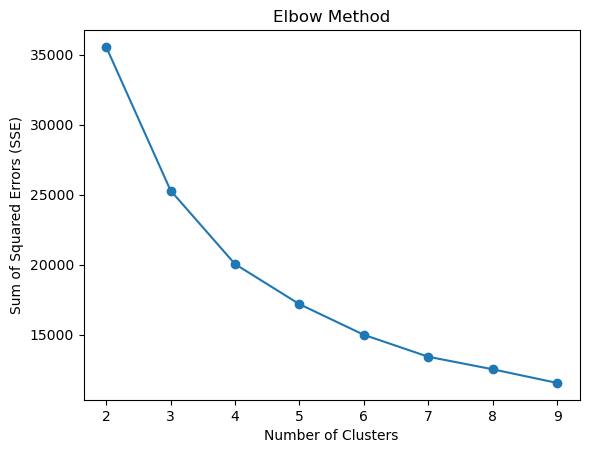

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sse = []  # List to store sum of squared errors for each value of k

# Loop through cluster counts from 2 to 9
for k in range(2, 10):
    # Initialize KMeans with k clusters and fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model on the scaled data
    kmeans.fit(x_scaled)
    
    # Append the inertia (sum of squared distances of samples to nearest cluster center)
    sse.append(kmeans.inertia_)  # inertia_ represents total within-cluster sum of squares

# Plot the SSE vs. number of clusters
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()


_k incerases, sse decreases. slope decreases.k=4_

The optimal number of clusters is often chosen where the "elbow" appears in the Elbow Method plot—this is the point where increasing k no longer substantially reduces the Sum of Squared Errors (SSE). In the plot, when k increases from 2 to 4, the SSE drops sharply, but after k=4, the decrease becomes much more gradual and the slope flattens. This indicates that adding more clusters beyond k=4 yields diminishing returns in terms of variance explained. Therefore, k=4 is chosen because it balances model complexity and explained variance, capturing the major structure in the data without unnecessary splitting.

# __STEP 5: Use k=4 Means Clustering to fit x_scaled__

In [16]:
# Initialize KMeans with the chosen number of clusters (4) and fixed random seed for reproducibility
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the KMeans model to the scaled data and assign cluster labels to each data point
# The result is stored as a new column 'cluster' in the rfm DataFrame
rfm['cluster'] = kmeans.fit_predict(x_scaled)
rfm

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Class,cluster
CustomerID,,,,,,,,,
C00001,7,12,2355.48,5,4,5,545,545,0
C00002,62,13,1375.04,3,4,3,343,343,3
C00003,275,8,1156.69,1,2,2,122,122,2
C00004,70,7,1692.09,3,1,4,314,314,1
C00005,16,9,1819.42,5,2,4,524,524,3
...,...,...,...,...,...,...,...,...,...
C19996,15,12,1751.18,5,4,4,544,544,3
C19997,93,12,1441.84,2,4,3,243,243,3
C19998,9,8,1243.01,5,2,2,522,522,1


# __STEP 6: Clustering Evaluation--silhouette_score__

In [17]:
from sklearn.metrics import silhouette_score

# Calculate the average silhouette score for the clustering result
# silhouette_score measures how similar an object is to its own cluster compared to other clusters
silhouette_avg = silhouette_score(x_scaled, rfm['cluster'])

# Print the average silhouette score rounded to 2 decimal places
print(f'Silhouette Score: {silhouette_avg:.2f}')


Silhouette Score: 0.31


A Silhouette Score of 0.31 indicates a weak clustering structure overall. Here is the interpretation:

- The silhouette score ranges from -1 to +1, where values close to +1 imply well-separated and dense clusters.
- Scores around 0 indicate data points are near cluster boundaries.
- Scores below 0 suggest some points may be assigned to the wrong cluster.
- A value of 0.31 means the clusters are somewhat separated but not very distinct; it suggests moderate cluster cohesion and separation.
- Often, scores above 0.5 are considered reasonable clustering, while scores above 0.7 are strong.
- For high-dimensional or complex data, lower scores like 0.31 can still be acceptable, but it signals the clustering could be improved or that the natural clusters may be weakly defined in the data.

_In summary, a silhouette score of 0.31 implies the clustering works but is relatively weak, indicating modest separation and cohesion between clusters._

# __STEP 6: PCA Dimension Reduction & Visualization of Clusters__

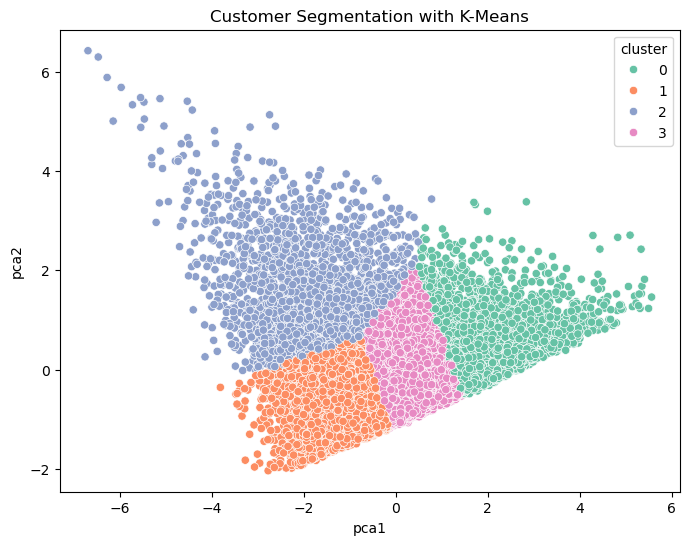

In [18]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce data dimensions to 2 components for visualization
pca = PCA(n_components=2)

# Fit PCA on scaled data and transform it to get the first 2 principal components
x_pca = pca.fit_transform(x_scaled)

# Add the principal component scores as new columns in the rfm DataFrame
rfm['pca1'] = x_pca[:, 0]  # First principal component
rfm['pca2'] = x_pca[:, 1]  # Second principal component

# Create a figure with specified size for clear visualization
plt.figure(figsize=(8, 6))

# Scatter plot of the two principal components colored by cluster assignments
sns.scatterplot(data=rfm, x='pca1', y='pca2', hue='cluster', palette='Set2')

# Add a title to the plot
plt.title('Customer Segmentation with K-Means')

# Show the plot
plt.show()


In [19]:
x_scaled

array([[-0.93175383,  0.63724789,  1.24604399],
       [-0.34741363,  0.95586388, -0.32357247],
       [ 1.91557663, -0.63721603, -0.67313568],
       ...,
       [-0.9105051 , -0.63721603, -0.53494335],
       [-0.4855304 ,  1.59309584,  1.51070984],
       [-0.50677914,  0.95586388,  2.16806798]])

In [20]:
x

,Recency,Frequency,Monetary
CustomerID,,,
C00001,7,12,2355.48
C00002,62,13,1375.04
C00003,275,8,1156.69
C00004,70,7,1692.09
C00005,16,9,1819.42
...,...,...,...
C19996,15,12,1751.18
C19997,93,12,1441.84
C19998,9,8,1243.01


In [21]:
cluster_summary=rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
cluster_summary

,Recency,Frequency,Monetary
cluster,,,
0,60.0,14.4,2490.0
1,75.1,7.2,1012.4
2,291.4,7.4,1146.0
3,67.0,10.7,1681.6


In [22]:
data = {
    'Cluster': [0, 1, 2, 3],
    'Recency': [60.0, 75.1, 291.4, 67.0],
    'Frequency': [14.4, 7.2, 7.4, 10.7],
    'Monetary': [2490.0, 1012.4, 1146.0, 1681.6]
}
dataframe = pd.DataFrame(data)
dataframe

,Cluster,Recency,Frequency,Monetary
0,0,60.0,14.4,2490.0
1,1,75.1,7.2,1012.4
2,2,291.4,7.4,1146.0
3,3,67.0,10.7,1681.6


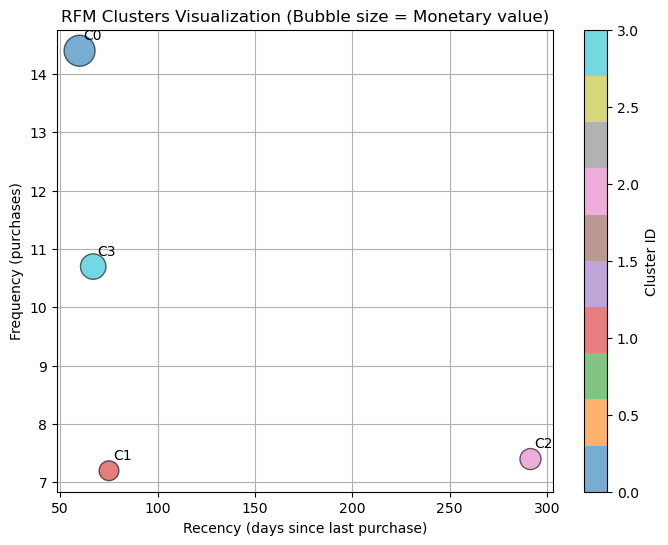

In [23]:
# 气泡大小
sizes = dataframe['Monetary'] / 5  # 缩小比例

# 绘图
plt.figure(figsize=(8, 6))
scatter = plt.scatter(dataframe['Recency'], dataframe['Frequency'], s=sizes, alpha=0.6, c=dataframe['Cluster'], cmap='tab10', edgecolors='k')

# 添加标注
for i, row in dataframe.iterrows():
    plt.text(row['Recency']+2, row['Frequency']+0.2, f"C{int(row['Cluster'])}", fontsize=10)

plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (purchases)")
plt.title("RFM Clusters Visualization (Bubble size = Monetary value)")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

| Cluster                             | 特征总结                       | 可能的客户类型      | 营销建议                                      |
| ----------------------------------- | -------------------------- | ------------ | ----------------------------------------- |
| **0**<br>(R=60.0, F=14.4, M=2490.0) | 最近消费天数低（活跃），购买频率很高，金额最高    | **核心高价值客户**  | 维护忠诚度：会员专属优惠、提前体验新产品、定制化服务。避免流失，这类人是营收核心。 |
| **1**<br>(R=75.1, F=7.2, M=1012.4)  | 活跃度还可以（刚过两个月），频次中等，金额中等    | **中高价值活跃客户** | 可培养为核心客户：多给促销券、产品推荐，鼓励更多购买频次。             |
| **2**<br>(R=291.4, F=7.4, M=1146.0) | 很久没买（快 10 个月），但曾经购买频次和金额中等 | **沉睡老客户**    | 唤醒营销：邮件/短信召回，限定时优惠，提醒曾买过的产品有新版本。          |
| **3**<br>(R=67.0, F=10.7, M=1681.6) | 最近消费较近，频次和金额都偏高            | **潜力高价值客户**  | 加速培养：会员积分计划、交叉销售（Cross-sell），让他们更频繁购买。    |

# __ADDITIONAL ACTIVITY: KMEANS CLUSTERING WITH OTHER FEATURES WITH PCA DIMENSION REDUCTION; DBSCAN CLUSTERING; HIERCHICAL CLUSTERING__

In [24]:
df

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalAmount,Category,Country,Channel,Age,Gender,Membership,RegistrationDate,Occupation
0,C03649,INV126225,2025-01-29,5,19.82,99.10,Home,UK,Online,35,Female,NaN,2024-09-10,Sales
1,C04573,INV872246,2023-04-15,1,87.29,87.29,Books,India,Mobile,21,Other,NaN,2024-08-18,Sales
2,C02849,INV719176,2024-03-08,3,97.14,291.42,Electronics,USA,Online,27,Other,Silver,2023-02-22,Student
3,C07165,INV343962,2024-06-01,3,22.42,67.26,Toys,USA,Mobile,24,Female,NaN,2023-04-23,Manager
4,C06516,INV850800,2024-10-27,3,32.67,98.01,Books,China,In-store,30,Male,Gold,2023-05-14,Artist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,C17221,INV412170,2024-07-05,3,97.70,293.10,Toys,China,In-store,19,Female,Silver,2023-06-18,Engineer
199996,C18255,INV168135,2025-05-19,3,22.74,68.22,Beauty,UK,Mobile,56,Other,Silver,2024-02-20,Artist
199997,C07925,INV171285,2024-12-25,3,59.43,178.29,Beauty,Germany,Mobile,25,Male,Gold,2023-10-25,Artist
199998,C03630,INV964222,2024-06-17,3,9.09,27.27,Books,Brazil,Online,40,Male,NaN,2023-12-22,Artist


In [25]:
rfm

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Class,cluster,pca1,pca2
CustomerID,,,,,,,,,,,
C00001,7,12,2355.48,5,4,5,545,545,0,1.582662,-0.321868
C00002,62,13,1375.04,3,4,3,343,343,3,0.554699,-0.207363
C00003,275,8,1156.69,1,2,2,122,122,2,-1.588749,1.409667
C00004,70,7,1692.09,3,1,4,314,314,1,-0.411548,-0.398822
C00005,16,9,1819.42,5,2,4,524,524,3,0.360375,-0.719873
...,...,...,...,...,...,...,...,...,...,...,...
C19996,15,12,1751.18,5,4,4,544,544,3,0.924740,-0.549109
C19997,93,12,1441.84,2,4,3,243,243,3,0.287495,0.058308
C19998,9,8,1243.01,5,2,2,522,522,1,-0.418009,-1.151592


In [26]:
import pandas as pd

df = df.reset_index()  # if CustomerID is index here
rfm = rfm.reset_index()  # if CustomerID is index here
# Merge on 'CustomerID' using an inner join to keep only matching customers
merged_df = pd.merge(df, rfm, on='CustomerID', how='inner')
merged_df

,index,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalAmount,Category,Country,Channel,...,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Class,cluster,pca1,pca2
0,0,C03649,INV126225,2025-01-29,5,19.82,99.10,Home,UK,Online,...,9,1325.92,2,2,2,222,222,1,-0.585357,0.078412
1,1,C04573,INV872246,2023-04-15,1,87.29,87.29,Books,India,Mobile,...,13,1246.03,3,5,2,352,352,3,0.388661,-0.194258
2,2,C02849,INV719176,2024-03-08,3,97.14,291.42,Electronics,USA,Online,...,12,1680.21,5,4,3,543,543,3,0.879750,-0.653548
3,3,C07165,INV343962,2024-06-01,3,22.42,67.26,Toys,USA,Mobile,...,6,850.55,1,1,1,111,111,1,-1.883059,0.044055
4,4,C06516,INV850800,2024-10-27,3,32.67,98.01,Books,China,In-store,...,8,1708.20,1,2,4,124,124,2,-1.034245,1.727728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,C17221,INV412170,2024-07-05,3,97.70,293.10,Toys,China,In-store,...,14,1838.48,5,5,4,554,554,0,1.415375,-0.312623
199996,199996,C18255,INV168135,2025-05-19,3,22.74,68.22,Beauty,UK,Mobile,...,12,2059.71,5,4,4,544,544,3,1.268434,-0.451848
199997,199997,C07925,INV171285,2024-12-25,3,59.43,178.29,Beauty,Germany,Mobile,...,11,1566.27,2,4,3,243,243,3,0.169374,0.137678
199998,199998,C03630,INV964222,2024-06-17,3,9.09,27.27,Books,Brazil,Online,...,12,2084.31,4,4,5,445,445,3,1.143472,-0.077072


In [27]:
features=merged_df[['Category','Country','Channel','Membership','Recency','Frequency','Monetary','Age','Gender','Occupation']]
features

,Category,Country,Channel,Membership,Recency,Frequency,Monetary,Age,Gender,Occupation
0,Home,UK,Online,NaN,123,9,1325.92,35,Female,Sales
1,Books,India,Mobile,NaN,70,13,1246.03,21,Other,Sales
2,Electronics,USA,Online,Silver,8,12,1680.21,27,Other,Student
3,Toys,USA,Mobile,NaN,166,6,850.55,24,Female,Manager
4,Books,China,In-store,Gold,279,8,1708.20,30,Male,Artist
...,...,...,...,...,...,...,...,...,...,...
199995,Toys,China,In-store,Silver,20,14,1838.48,19,Female,Engineer
199996,Beauty,UK,Mobile,Silver,9,12,2059.71,56,Other,Artist
199997,Beauty,Germany,Mobile,Gold,102,11,1566.27,25,Male,Artist
199998,Books,Brazil,Online,NaN,46,12,2084.31,40,Male,Artist


In [28]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Isolate categorical and numerical columns
categorical_cols = ['Category', 'Country', 'Channel', 'Gender', 'Occupation','Membership']
numerical_cols = ['Recency', 'Frequency', 'Monetary', 'Age']

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(features[categorical_cols])
cat_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_cat_df = pd.DataFrame(encoded_cats, columns=cat_feature_names, index=features.index)

# Standard scale numerical variables
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(features[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_nums, columns=numerical_cols, index=features.index)

# Concatenate numerical and encoded categorical variables
features_processed= pd.concat([scaled_num_df, encoded_cat_df], axis=1)
features_processed

,Recency,Frequency,Monetary,Age,Category_Books,Category_Electronics,Category_Fashion,Category_Home,Category_Toys,Country_China,...,Gender_Male,Gender_Other,Occupation_Engineer,Occupation_Manager,Occupation_Other,Occupation_Sales,Occupation_Student,Membership_Platinum,Membership_Silver,Membership_nan
0,0.449192,-0.635243,-0.640958,-0.551175,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.183998,0.644818,-0.766301,-1.481126,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.924711,0.324803,-0.085100,-1.082575,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.962912,-1.595289,-1.386783,-1.281851,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.312922,-0.955259,-0.041185,-0.883300,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,-0.781347,0.964834,0.163216,-1.613976,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199996,-0.912764,0.324803,0.510312,0.843752,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199997,0.198305,0.004787,-0.263864,-1.215425,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,-0.470726,0.324803,0.548907,-0.219049,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
features_processed.columns

Index(['Recency', 'Frequency', 'Monetary', 'Age', 'Category_Books',
       'Category_Electronics', 'Category_Fashion', 'Category_Home',
       'Category_Toys', 'Country_China', 'Country_France', 'Country_Germany',
       'Country_India', 'Country_UK', 'Country_USA', 'Channel_Mobile',
       'Channel_Online', 'Gender_Male', 'Gender_Other', 'Occupation_Engineer',
       'Occupation_Manager', 'Occupation_Other', 'Occupation_Sales',
       'Occupation_Student', 'Membership_Platinum', 'Membership_Silver',
       'Membership_nan'],
      dtype='object')

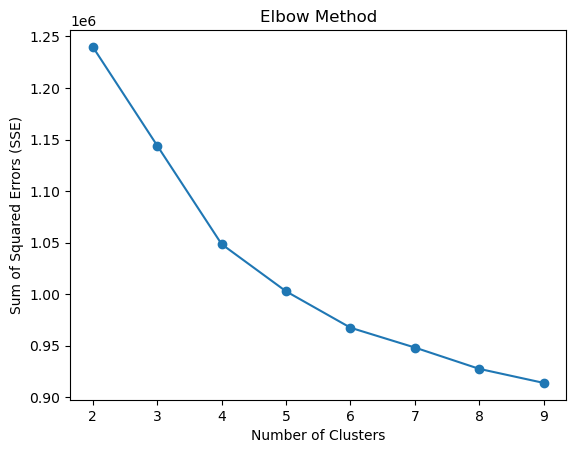

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sse = []  # List to store sum of squared errors for each value of k

# Loop through cluster counts from 2 to 9
for k in range(2, 10):
    # Initialize KMeans with k clusters and fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=48)
    
    # Fit the model on the scaled data
    kmeans.fit(features_processed)
    
    # Append the inertia (sum of squared distances of samples to nearest cluster center)
    sse.append(kmeans.inertia_)  # inertia_ represents total within-cluster sum of squares

# Plot the SSE vs. number of clusters
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()

k=6; we create 6 clusters

In [31]:
# Initialize KMeans with the chosen number of clusters (4) and fixed random seed for reproducibility
kmeans = KMeans(n_clusters=6, random_state=48)

# Fit the K-Means model to the scaled data and assign cluster labels to each data point
# The result is stored as a new column 'cluster' in the rfm DataFrame
merged_df['CLUSTER'] = kmeans.fit_predict(features_processed)
merged_df

,index,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalAmount,Category,Country,Channel,...,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Class,cluster,pca1,pca2,CLUSTER
0,0,C03649,INV126225,2025-01-29,5,19.82,99.10,Home,UK,Online,...,1325.92,2,2,2,222,222,1,-0.585357,0.078412,5
1,1,C04573,INV872246,2023-04-15,1,87.29,87.29,Books,India,Mobile,...,1246.03,3,5,2,352,352,3,0.388661,-0.194258,1
2,2,C02849,INV719176,2024-03-08,3,97.14,291.42,Electronics,USA,Online,...,1680.21,5,4,3,543,543,3,0.879750,-0.653548,1
3,3,C07165,INV343962,2024-06-01,3,22.42,67.26,Toys,USA,Mobile,...,850.55,1,1,1,111,111,1,-1.883059,0.044055,5
4,4,C06516,INV850800,2024-10-27,3,32.67,98.01,Books,China,In-store,...,1708.20,1,2,4,124,124,2,-1.034245,1.727728,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,C17221,INV412170,2024-07-05,3,97.70,293.10,Toys,China,In-store,...,1838.48,5,5,4,554,554,0,1.415375,-0.312623,1
199996,199996,C18255,INV168135,2025-05-19,3,22.74,68.22,Beauty,UK,Mobile,...,2059.71,5,4,4,544,544,3,1.268434,-0.451848,0
199997,199997,C07925,INV171285,2024-12-25,3,59.43,178.29,Beauty,Germany,Mobile,...,1566.27,2,4,3,243,243,3,0.169374,0.137678,1
199998,199998,C03630,INV964222,2024-06-17,3,9.09,27.27,Books,Brazil,Online,...,2084.31,4,4,5,445,445,3,1.143472,-0.077072,1


In [32]:
customer_detail_cluster_summary=merged_df.groupby('CLUSTER')[['Recency', 'Frequency', 'Monetary', 'Age']].mean().round(0)
customer_detail_cluster_summary

,Recency,Frequency,Monetary,Age
CLUSTER,,,,
0,63.0,12.0,1990.0,57.0
1,62.0,12.0,1997.0,30.0
2,276.0,8.0,1309.0,43.0
3,54.0,16.0,2887.0,43.0
4,70.0,8.0,1213.0,57.0
5,72.0,9.0,1238.0,30.0


# Customer Cluster Characteristics

| Cluster | Recency | Frequency | Monetary | Age | Interpretation |
|---------|---------|-----------|----------|-----|---------------|
| 0       | 63      | 12        | 1991     | 57  | Older, loyal and valuable: frequent, high spenders with moderate recency. |
| 1       | 70      | 8         | 1214     | 57  | Older, less frequent, moderate spenders: lower engagement, possible decline in activity. |
| 2       | 277     | 8         | 1309     | 43  | Lapsed/inactive: made infrequent purchases, last transaction was a long time ago. |
| 3       | 54      | 16        | 2887     | 43  | Best customers: most active, highest spenders, and purchased most recently. |
| 4       | 72      | 9         | 1237     | 30  | Young, infrequent, moderate spenders: less engaged, newer or growth segment. |
| 5       | 62      | 12        | 1997     | 30  | Young, loyal and valuable: emerging top customers, frequent and high spenders. |

---

## Segment Summary

- **Cluster 3:** Best customers (most frequent, highest spend, and recent activity)
- **Cluster 2:** Lapsed/inactive segment
- **Clusters 0 & 5:** Loyal and valuable, differing by age group (older vs. younger)
- **Clusters 1 & 4:** Moderate value and engagement, differentiated by age

These insights enable targeted strategies for retention, winback, and recognizing high-value segments.


In [33]:
#from sklearn.metrics import silhouette_score

# Calculate the average silhouette score for the clustering result
# silhouette_score measures how similar an object is to its own cluster compared to other clusters
#silhouette_avg = silhouette_score(features_processed, merged_df['CLUSTER'])

# Print the average silhouette score rounded to 2 decimal places
#print(f'Silhouette Score: {silhouette_avg:.2f}')

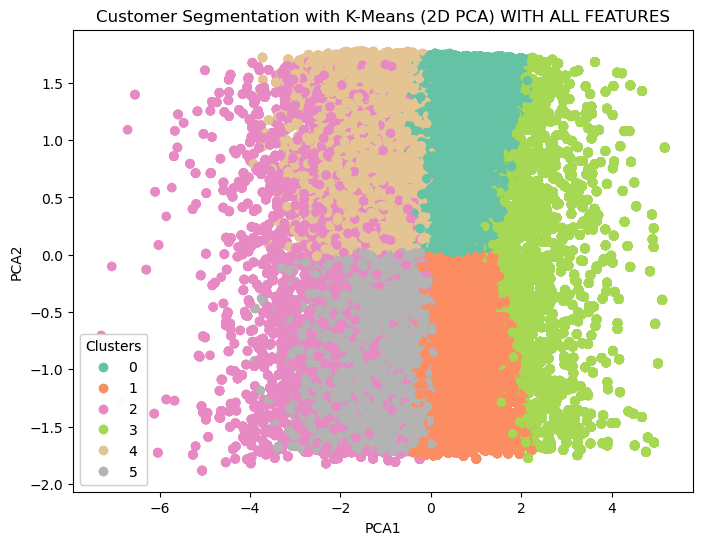

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA and transform scaled data
x2_pca = pca.fit_transform(features_processed)

# Add PCA components to DataFrame
merged_df['pca_1'] = x2_pca[:, 0]
merged_df['pca_2'] = x2_pca[:, 1]

# Create 2D scatter plot using a standard 2D axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot with color based on cluster labels
scatter = ax.scatter(merged_df['pca_1'], merged_df['pca_2'], c=merged_df['CLUSTER'], cmap='Set2')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Customer Segmentation with K-Means (2D PCA) WITH ALL FEATURES')
plt.show()


# RFM Analysis Common Pitfalls and Considerations

## Data Quality Issues
| Issue | Description | Recommended Solution |
|---|---|---|
| Unreasonable Time Window | RFM results are highly dependent on the selected time period. Too short may miss patterns; too long may include outdated behaviors | Use business cycles (3-6 months for retail, 1-2 years for automotive) |
| Focusing Only on RFM Total Score | Simple averaging may hide important patterns (e.g., R=1, F=5, M=5 indicates at-risk high-value customers) | Analyze each dimension separately and use combination rules |
| Ignoring Monetary Extremes | A few whale customers can skew the entire Monetary distribution | Use quantile-based binning (percentiles) instead of equal intervals |
| Industry Applicability | Works best for frequent, moderate-value purchases; less effective for infrequent, high-value transactions | Adapt scoring rules: for luxury goods, weight M more heavily; for subscriptions, weight F more |

# Extended RFM Applications

## Advanced Analytical Methods

| Method | Application | Business Value |
|---|---|---|
| **RFM + KMeans Clustering** | Automatically identify customer segments beyond manual RFM scoring | Discovers hidden patterns and unexpected customer groups |
| **RFM + Customer Lifetime Value** | Combine historical RFM with predictive CLV models | Identify future high-value customers, not just current ones |
| **RFM + Time Series Analysis** | Track how customer segments evolve over time | Early warning for segment migration and churn prediction |
| **RFM + Recommendation Systems** | Personalize product recommendations based on customer value tiers | Optimize resource allocation for maximum ROI |

## Implementation Considerations
- **Data Quality**: Ensure consistent data collection across all customer touchpoints
- **Scoring Calibration**: Regularly review and adjust scoring thresholds based on business changes
- **Actionable Insights**: Connect RFM segments to specific marketing actions and budget allocations
- **Integration**: Combine RFM with other customer data (demographics, behavior, satisfaction scores)

# Customer Segments for Campaigns

| Cluster                             | 特征总结                       | 可能的客户类型      | 营销建议                                      |
| ----------------------------------- | -------------------------- | ------------ | ----------------------------------------- |
| **0**<br>(R=60.0, F=14.4, M=2490.0) | 最近消费天数低（活跃），购买频率很高，金额最高    | **核心高价值客户**  | 维护忠诚度：会员专属优惠、提前体验新产品、定制化服务。避免流失，这类人是营收核心。 |
| **1**<br>(R=75.1, F=7.2, M=1012.4)  | 活跃度还可以（刚过两个月），频次中等，金额中等    | **中高价值活跃客户** | 可培养为核心客户：多给促销券、产品推荐，鼓励更多购买频次。             |
| **2**<br>(R=291.4, F=7.4, M=1146.0) | 很久没买（快 10 个月），但曾经购买频次和金额中等 | **沉睡老客户**    | 唤醒营销：邮件/短信召回，限定时优惠，提醒曾买过的产品有新版本。          |
| **3**<br>(R=67.0, F=10.7, M=1681.6) | 最近消费较近，频次和金额都偏高            | **潜力高价值客户**  | 加速培养：会员积分计划、交叉销售（Cross-sell），让他们更频繁购买。    |

# Core High-Value Customers (Segment 0): Campaign & Pre-Launch A/B Testing

**Goals & Strategy**
- Aim to boost repeat purchase rate, increase average order value, and strengthen brand loyalty through exclusive membership benefits, early access to products, and customized experiences. 

**Campaign Designs**
- __Member-Only Days__: Organize exclusive shopping events for members, offering special discounts and early access to products.  
- __Customized Services__: Provide tailored gift packs or limited-edition bundles that match individual member preferences.  
- __Presale Experience__: Distribute trial samples or experience vouchers prior to new product launches.  

  <img src="segment 0.png" alt="segment 0" width="1000"/>


**Key A/B Tests & Success Metrics**
- **Test 1:** Analyze the effect of exclusive member discounts (yes/no) on conversion rate and order value.  
  **Success Metrics:** Conversion rate, average order value.
- **Test 2:** Compare repeat purchase rates between customers receiving customized versus general gift packs.  
  **Success Metrics:** Repeat purchase rate, monthly retention rate.
- **Test 3:** Evaluate the impact of offering trial vouchers for new product first-week sales.  
  **Success Metrics:** First-week sales volume, Net Promoter Score (NPS), customer satisfaction.


In [16]:
segment0_test1=pd.read_csv('segment0_test1.csv')
segment0_test1

,Test_ID,Test_Name,Treatment,Conversion,Order_Value
0,1,Exclusive Member Discounts,Yes,0,0.00
1,1,Exclusive Member Discounts,Yes,1,22.65
2,1,Exclusive Member Discounts,Yes,1,16.25
3,1,Exclusive Member Discounts,Yes,0,0.00
4,1,Exclusive Member Discounts,Yes,0,0.00
...,...,...,...,...,...
995,1,Exclusive Member Discounts,No,0,0.00
996,1,Exclusive Member Discounts,No,0,0.00
997,1,Exclusive Member Discounts,No,0,0.00
998,1,Exclusive Member Discounts,No,1,20.36


In [15]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Load dataset
segment0_test1 = pd.read_csv('segment0_test1.csv')

# Split groups by treatment
yes = segment0_test1[segment0_test1['Treatment'] == 'Yes']
no = segment0_test1[segment0_test1['Treatment'] == 'No']

# Conversion rate and z-test
conv_yes = yes['Conversion'].sum()
conv_no = no['Conversion'].sum()
n_yes = len(yes)
n_no = len(no)
zstat, pval_conv = proportions_ztest([conv_yes, conv_no], [n_yes, n_no])

# Average order value and Mann-Whitney U test (non-parametric)
order_yes = yes['Order_Value'][yes['Conversion'] == 1]
order_no = no['Order_Value'][no['Conversion'] == 1]
u_stat, pval_order = mannwhitneyu(order_yes, order_no, alternative='two-sided')

# Print results
print(f'Conversion Rate - Yes: {conv_yes/n_yes:.3f}, No: {conv_no/n_no:.3f}')
print(f'Conversion Rate Z-test statistic: {zstat:.4f}, p-value: {pval_conv:.4f}')
print(f'Average Order Value - Yes: {order_yes.mean():.2f}, No: {order_no.mean():.2f}')
print(f'Mann-Whitney U test statistic: {u_stat}, p-value: {pval_order:.4f}')


Conversion Rate - Yes: 0.164, No: 0.086
Conversion Rate Z-test statistic: 3.7291, p-value: 0.0002
Average Order Value - Yes: 20.79, No: 18.78
Mann-Whitney U test statistic: 2622.5, p-value: 0.0000


In [41]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Load dataset
segment0_test2= pd.read_csv('segment0_test2.csv')

# Separate groups
custom = segment0_test2[segment0_test2['Treatment'] == 'Customized']
general = segment0_test2[segment0_test2['Treatment'] == 'General']

# Repeat Purchase test (conversion test for repeat purchase)
repeat_custom = custom['Repeat_Purchase'].sum()
repeat_general = general['Repeat_Purchase'].sum()
n_custom = len(custom)
n_general = len(general)
zstat_repeat, pval_repeat = proportions_ztest([repeat_custom, repeat_general], [n_custom, n_general])

# Monthly Retention test
retention_custom = custom['Monthly_Retention'].sum()
retention_general = general['Monthly_Retention'].sum()
zstat_ret, pval_ret = proportions_ztest([retention_custom, retention_general], [n_custom, n_general])

# Print results
print(f'Repeat Purchase Rate - Customized: {repeat_custom/n_custom:.3f}, General: {repeat_general/n_general:.3f}')
print(f'Repeat Purchase Z-test: Z={zstat_repeat:.4f}, p={pval_repeat:.4g}')
print(f'Monthly Retention Rate - Customized: {retention_custom/n_custom:.3f}, General: {retention_general/n_general:.3f}')
print(f'Monthly Retention Z-test: Z={zstat_ret:.4f}, p={pval_ret:.4g}')


Repeat Purchase Rate - Customized: 0.400, General: 0.270
Repeat Purchase Z-test: Z=4.3549, p=1.331e-05
Monthly Retention Rate - Customized: 0.778, General: 0.660
Monthly Retention Z-test: Z=4.1508, p=3.313e-05


In [2]:
import pandas as pd
from scipy.stats import ttest_ind

# Load dataset
segment0_test3= pd.read_csv('segment0_test3.csv')

# Separate groups
voucher = segment0_test3[segment0_test3['Treatment'] == 'Voucher']
control = segment0_test3[segment0_test3['Treatment'] == 'Control']

# First-week sales volume test (independent t-test)
tstat_sales, pval_sales = ttest_ind(voucher['First_Week_Sales_Volume'], control['First_Week_Sales_Volume'], equal_var=False)

# NPS test (independent t-test)
tstat_nps, pval_nps = ttest_ind(voucher['NPS'], control['NPS'], equal_var=False)

# Customer Satisfaction test (independent t-test)
tstat_cust_sat, pval_cust_sat = ttest_ind(voucher['Customer_Satisfaction'], control['Customer_Satisfaction'], equal_var=False)

# Print results
print(f'First-Week Sales Volume: t-statistic={tstat_sales:.4f}, p-value={pval_sales:.4g}')
print(f'NPS: t-statistic={tstat_nps:.4f}, p-value={pval_nps:.4g}')
print(f'Customer Satisfaction: t-statistic={tstat_cust_sat:.4f}, p-value={pval_cust_sat:.4g}')

First-Week Sales Volume: t-statistic=14.6000, p-value=7.02e-44
NPS: t-statistic=9.2934, p-value=9.439e-20
Customer Satisfaction: t-statistic=16.7962, p-value=2.985e-55


## Mid-High Value Active Customers (Segment 1): Campaign & Pre-Launch A/B Testing

### Goals & Strategy
- **Aim:** Increase purchase frequency and order value; nurture into core customers.
- **Strategy:** Multi-channel promo codes, personalized recommendations, limited-time product bundles.

### Campaign Designs
- **Promo Limited Offering:** Discount codes sent by email & SMS, valid for 2–3 days.
- **Combo Offers:** Combo offers on related products driven by purchase history.
- **Purchase Incentives:** Bonus points for use on next order after purchase.
  
  <img src="Segment 1.png" alt="Segment 1" width="1000"/>
   
### Key A/B Tests & Success Metrics
- **A/B 1:** Promo code validity (48hr vs 96hr) 
  **Success Metrics:** Conversion rate, repeat purchase rate.
- **A/B 2:** Personalized recommendations (yes vs no). 
  **Success Metrics:** Average order value.
- **A/B 3:** Bonus points on purchase (yes vs no). 
  **Success Metrics:** Average order value, repurchase interval.

In [5]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load dataset
segment1_test1 = pd.read_csv('segment1_test1.csv')

# Separate treatment groups
group_48hr = segment1_test1[segment1_test1['Treatment'] == '48hr']
group_96hr = segment1_test1[segment1_test1['Treatment'] == '96hr']

# Conversion rate comparison (proportions z-test)
conv_48hr = group_48hr['Conversion'].sum()
conv_96hr = group_96hr['Conversion'].sum()
n_48hr = len(group_48hr)
n_96hr = len(group_96hr)
zstat_conv, pval_conv = proportions_ztest([conv_48hr, conv_96hr], [n_48hr, n_96hr])

# Repeat purchase rate comparison (proportions z-test)
repeat_48hr = group_48hr['Repeat_Purchase'].sum()
repeat_96hr = group_96hr['Repeat_Purchase'].sum()
zstat_rep, pval_rep = proportions_ztest([repeat_48hr, repeat_96hr], [n_48hr, n_96hr])

# Print results
print(f'Conversion Rate - 48hr: {conv_48hr/n_48hr:.3f}, 96hr: {conv_96hr/n_96hr:.3f}')
print(f'Conversion rate Z-test: Z={zstat_conv:.4f}, p={pval_conv:.4g}')
print(f'Repeat Purchase Rate - 48hr: {repeat_48hr/n_48hr:.3f}, 96hr: {repeat_96hr/n_96hr:.3f}')
print(f'Repeat purchase rate Z-test: Z={zstat_rep:.4f}, p={pval_rep:.4g}')


Conversion Rate - 48hr: 0.194, 96hr: 0.136
Conversion rate Z-test: Z=2.4707, p=0.01349
Repeat Purchase Rate - 48hr: 0.352, 96hr: 0.240
Repeat purchase rate Z-test: Z=3.8793, p=0.0001047


In [7]:
import pandas as pd
from scipy.stats import ttest_ind

# Load dataset
segment1_test2 = pd.read_csv('segment1_test2.csv')

# Split by treatment group
group_yes = segment1_test2[segment1_test2['Treatment'] == 'Yes']['Average_Order_Value']
group_no = segment1_test2[segment1_test2['Treatment'] == 'No']['Average_Order_Value']

# Perform t-test
t_stat, p_val = ttest_ind(group_yes, group_no, equal_var=False)

# Print results
print(f'Average Order Value - Yes group mean: {group_yes.mean():.2f}')
print(f'Average Order Value - No group mean: {group_no.mean():.2f}')
print(f'T-test statistic: {t_stat:.4f}, p-value: {p_val:.4g}')

Average Order Value - Yes group mean: 49.70
Average Order Value - No group mean: 44.99
T-test statistic: 15.4768, p-value: 1.374e-48


In [2]:
import pandas as pd
from scipy.stats import ttest_ind

# 读取数据
df = pd.read_csv('segment1_test3.csv')

# 拆分两组（有积分和无积分）
group_yes_aov = df[df['Treatment'] == 'Yes']['AverageOrderValue']
group_no_aov = df[df['Treatment'] == 'No']['AverageOrderValue']

group_yes_repurchase = df[df['Treatment'] == 'Yes']['RepurchaseInterval']
group_no_repurchase = df[df['Treatment'] == 'No']['RepurchaseInterval']

# 对平均订单金额做t检验（Welch不等方差）
t_stat_aov, p_val_aov = ttest_ind(group_yes_aov, group_no_aov, equal_var=False)

# 对复购间隔做t检验
t_stat_repurchase, p_val_repurchase = ttest_ind(group_yes_repurchase, group_no_repurchase, equal_var=False)

# 输出结果
print(f'Average Order Value - Yes group mean: {group_yes_aov.mean():.2f}')
print(f'Average Order Value - No group mean: {group_no_aov.mean():.2f}')
print(f'T-test AOV: statistic={t_stat_aov:.4f}, p-value={p_val_aov:.4g}\n')

print(f'Repurchase Interval - Yes group mean: {group_yes_repurchase.mean():.2f}')
print(f'Repurchase Interval - No group mean: {group_no_repurchase.mean():.2f}')
print(f'T-test Repurchase Interval: statistic={t_stat_repurchase:.4f}, p-value={p_val_repurchase:.4g}')


Average Order Value - Yes group mean: 63.00
Average Order Value - No group mean: 63.15
T-test AOV: statistic=-0.1067, p-value=0.9153

Repurchase Interval - Yes group mean: 16.00
Repurchase Interval - No group mean: 15.58
T-test Repurchase Interval: statistic=0.7801, p-value=0.4372


### Mid-High Value Dormant Customers (Segment 2): Campaign & Pre-Launch A/B Testing

**Goals & Strategy**  
Aim: Reactivate dormant customers, stimulate repeat purchase, and recover customer value.  
Strategy: Targeted emails/SMS recalls, limited-time offers, personalized recommendations, combined with multi-channel continuous engagement.

**Campaign Designs**  
- **Reactivation Promo Offers:** Send exclusive recall coupons (valid for 3-5 days), utilize both email and SMS channels.  
- **Personalized Product Updates:** Push upgrade or new product recommendations based on past purchases.  
- **Win-back Incentives:** Offer special points or rewards redeemable on next purchase to encourage first repeat buy.

   <img src="segment 2.png" alt="segment 2" width="1000"/>

**Key A/B Tests & Success Metrics**  
| Test | Description                               | Success Metrics               |
|-------|-------------------------------------------|----------------------------|
| A/B 1 | Coupon validity ([translate:3 days vs 5 days])       | Reactivation rate, conversion rate |
| A/B 2 | Personalized recommendation ([translate:Yes vs No])   | Average order value, repeat purchase rate |
| A/B 3 | Repeat purchase bonus points ([translate:Yes vs No]) | Average order value, repurchase interval |


### Potential High-Value Customers (Segment 3): Campaign & Pre-Launch A/B Testing

**Goals & Strategy**  
Aim: Accelerate growth of high-potential customers into core customers with increased frequency and spend.  
Strategy: Enhance engagement through loyalty programs, advanced personalized recommendations, and tailored cross-sell bundles.

**Campaign Designs**  
- **Loyalty Points Enhancement:** Boost points earning and redemption opportunities to increase stickiness.  
- **Advanced Personalized Bundles:** Offer cross-sell and up-sell product bundles based on detailed purchase patterns.  
- **Exclusive Early Access:** Provide early access to new products and exclusive events to foster loyalty.

   <img src="segment 3.png" alt="segment 3 pictures" width="1000"/>

**Key A/B Tests & Success Metrics**  

| Test   | Description                                              | Success Metrics                                |
|--------|----------------------------------------------------------|------------------------------------------------|
| A/B 1  | Loyalty points multiplier (e.g., 1x vs 2x points)        | Repeat purchase rate, average order value      |
| A/B 2  | Personalized bundle offers ([translate:Yes vs No])       | Average order value, conversion rate            |
| A/B 3  | Early access messaging (standard vs exclusive)           | Customer engagement, repeat purchase frequency  |